<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Explore-other-reward-functions" data-toc-modified-id="Explore-other-reward-functions-1">Explore other reward functions</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-1.3">Code</a></span><ul class="toc-item"><li><span><a href="#Data-generation" data-toc-modified-id="Data-generation-1.3.1">Data generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.3.2">Evaluation</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-1.3.3">Visualization</a></span></li></ul></li><li><span><a href="#Exploring-with-softmax-policy" data-toc-modified-id="Exploring-with-softmax-policy-1.4">Exploring with softmax policy</a></span><ul class="toc-item"><li><span><a href="#Compare-epsilon-greedy-policy-against-softmax-policy" data-toc-modified-id="Compare-epsilon-greedy-policy-against-softmax-policy-1.4.1">Compare epsilon greedy policy against softmax policy</a></span><ul class="toc-item"><li><span><a href="#Elo-score" data-toc-modified-id="Elo-score-1.4.1.1">Elo score</a></span></li><li><span><a href="#Randomness-on-softmax-policy" data-toc-modified-id="Randomness-on-softmax-policy-1.4.1.2">Randomness on softmax policy</a></span></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-1.4.1.3">Comparison</a></span></li></ul></li><li><span><a href="#Generation" data-toc-modified-id="Generation-1.4.2">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.4.3">Evaluation</a></span><ul class="toc-item"><li><span><a href="#Baseline-(lr-1e-3)" data-toc-modified-id="Baseline-(lr-1e-3)-1.4.3.1">Baseline (lr 1e-3)</a></span></li><li><span><a href="#Learning-rate-5e-4" data-toc-modified-id="Learning-rate-5e-4-1.4.3.2">Learning rate 5e-4</a></span></li><li><span><a href="#Learning-rate-2e-4" data-toc-modified-id="Learning-rate-2e-4-1.4.3.3">Learning rate 2e-4</a></span></li><li><span><a href="#Learning-rate-1e-4" data-toc-modified-id="Learning-rate-1e-4-1.4.3.4">Learning rate 1e-4</a></span></li><li><span><a href="#Learning-rate-1e-5" data-toc-modified-id="Learning-rate-1e-5-1.4.3.5">Learning rate 1e-5</a></span></li><li><span><a href="#From-zero" data-toc-modified-id="From-zero-1.4.3.6">From zero</a></span></li><li><span><a href="#40k-matches" data-toc-modified-id="40k-matches-1.4.3.7">40k matches</a></span></li></ul></li></ul></li><li><span><a href="#Trying-to-iterate" data-toc-modified-id="Trying-to-iterate-1.5">Trying to iterate</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.5.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.5.2">Evaluation</a></span></li></ul></li><li><span><a href="#Useful-snippets" data-toc-modified-id="Useful-snippets-1.6">Useful snippets</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.7">Summary</a></span></li></ul></li></ul></div>

# Explore other reward functions

## Goal

The goal of this notebooks is to continue learning about the Q value function, but trying other reward methods.

This is a continuation of notebook 004, which had become too big. In this notebook I will split the functionality
of playing games and generating data from training from those games.

## Imports

In [1]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import kaggle_environments
from kaggle_environments import make
from kaggle_environments import evaluate
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
from tqdm.notebook import tqdm
import time
from itertools import permutations
from functools import partial
import gc
from concurrent.futures import ProcessPoolExecutor
import json
import logging
import glob
from IPython.display import clear_output
import tempfile

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import tensorflow.keras as keras

from hungry_geese import GameState
from hungry_geese.state import make_board_egocentric, get_head_position, combine_data, horizontal_simmetry, vertical_simmetry
from hungry_geese.utils import ACTIONS, opposite_action, get_timestamp, log_ram_usage, configure_logging
from hungry_geese.definitions import ACTION_TO_IDX
from hungry_geese.agents import EpsilonAgent, QValueAgent
from hungry_geese.evaluation import play_matches_in_parallel, monitor_progress
from hungry_geese.elo import EloRanking
from hungry_geese.model import simple_model, create_model_for_training

%config Completer.use_jedi = False

Loading environment football failed: No module named 'gfootball'


In [3]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

configure_logging(logging.INFO)
logger = logging.getLogger(__name__)

## Code

### Data generation

In [4]:
def play_matches_in_parallel_and_save_history(agents, max_workers=20, n_matches=1000,
                                              output_path=None,
                                              running_on_notebook=True):
    """
    Plays n_matches in parallel using ProcessPoolExecutor

    Parameters
    -----------
    agents : list
        List of the agents that we will use for playing
    """
    log_ram_usage()
    output_path = output_path or get_games_output_path(agents, n_matches)
    assert not os.path.exists(output_path), 'Output path already exists: %s' % output_path
    with ProcessPoolExecutor(max_workers=max_workers) as pool:
        matches_results = []
        submits = []
        for i in range(n_matches):
            if isinstance(agents, list):
                submits.append(pool.submit(play_game, agents=agents))
            elif callable(agents):
                submits.append(pool.submit(play_game, agents=agents()))
            else:
                raise TypeError(type(agents))
        monitor_progress(submits, running_on_notebook)
        matches_results = [submit.result() for submit in submits]
    
    log_ram_usage()
    logger.info('saving matches to json: %s' % output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump(matches_results, f)
        
    del submits
    del matches_results
    gc.collect()
    log_ram_usage()

def play_game(agents):
    env = make("hungry_geese")
    return env.run(agents=agents)

def get_games_output_path(agents, n_matches):
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agents[0]))[0], 
        os.path.splitext(os.path.basename(agents[1]))[0], 
        n_matches)
    return output_path

In [5]:
def test_agent(agent):
    print('Testing agent: %s' % agent)
    env = make('hungry_geese', debug=True)
    env.run([agent]*4)

In [6]:
def create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=None):
    """
    Creates train data without any simmetry
    
    Parameters
    ----------
    saved_games_paths : list of str
        Path to the games that we want to use
    reward_name : str
        Name of the reward function that we want to use
    output_path : str
        Path to the file were we are going to save the results
    max_workers : int
    agent_idx_range : list of int
        Idx of the agents we want to use for collecting data, if None all the agents
        will be used
    """
    env = make("hungry_geese")
    conf = env.configuration

    state = GameState(reward_name=reward_name)
    train_data = []
    agent_idx_range = agent_idx_range or list(range(4))
    
    for saved_games_path in tqdm(saved_games_paths, desc='looping over saved games'):
        log_ram_usage()
        with open(saved_games_path, 'r') as f:
            matches_results = json.load(f)
        log_ram_usage()
    
        for _ in tqdm(range(len(matches_results)), desc='Creating game data'):
            match = matches_results[0]
            for idx in agent_idx_range:
                state.reset()
                for step_idx, step in enumerate(match):
                    observation = step[0]['observation'].copy()
                    observation['index'] = idx
                    state.update(observation, conf)
                    if step_idx:
                        state.add_action(step[idx]['action'])
                    if not observation['geese'][idx]:
                        break
                train_data.append(state.prepare_data_for_training())
            del matches_results[0]
        
    log_ram_usage()
    logger.info('Going to combine the data')
    train_data = combine_data(train_data)
    log_ram_usage()
    logger.info('Size of the boards is %.1f GB (%s [%.1f GB])' % (
        train_data[0].nbytes/1e9,
        str([round(data.nbytes/1e9, 1) for data in train_data]),
        np.sum([data.nbytes/1e9 for data in train_data])))
    logger.info('Saving data on: %s' % output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.savez_compressed(output_path, boards=train_data[0], features=train_data[1], actions=train_data[2], rewards=train_data[3])
    del state
    del train_data
    gc.collect()
    log_ram_usage()

In [7]:
def create_train_data(agents, n_matches, reward_name, agent_idx_range=None):
    """
    Creates train data without any simmetry
    
    Parameters
    ----------
    agents : list of str
        Names or paths of the agents
    n_matches : int
        Number of matches to play
    reward_name : str
        Name of the reward function that we want to use
    max_workers : int
    agent_idx_range : list of int
        Idx of the agents we want to use for collecting data, if None all the agents
        will be used
    """
    saved_games_path = get_games_output_path(agents, n_matches)
    if not os.path.exists(saved_games_path):
        play_matches_in_parallel_and_save_history(agents, n_matches=n_matches)

    output_path = get_data_output_path(agents, n_matches, reward_name)
    create_train_data_from_saved_matches([saved_games_path], reward_name, output_path, agent_idx_range=agent_idx_range)
    
def get_data_output_path(agents, n_matches, reward_name):
    output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
        reward_name,
        os.path.splitext(os.path.basename(agents[0]))[0], 
        os.path.splitext(os.path.basename(agents[1]))[0], 
        n_matches)
    return output_file

### Evaluation

In [8]:
initial_elo_ranking = pd.read_csv('../data/elo_ranking.csv', index_col='model')
initial_elo_ranking

,ranking
model,
quantum,1398
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766


In [9]:
agents = {
    'random': 'random',
    'random_plus': '../forum/agents/random_plus.py',
    'greedy': 'greedy',
    'risk_averse_goose': '../forum/agents/risk_averse_goose.py',
    'goose_on_a_healthy_diet': '../forum/agents/goose_on_a_healthy_diet.py',
    'straightforward_bfs': '../forum/agents/straightforward_bfs.py',
    'boilergoose': '../forum/agents/boilergoose.py',
    'crazy_goose': '../forum/agents/crazy_goose.py',
    'besthoarder': '../forum/agents/besthoarder.py',
    'greedyhoarder': '../forum/agents/greedyhoarder.py',
    'quantum': '../data/agents/quantum/quantum.py',
}

In [10]:
def evaluate_agent(new_agent, adversary_agents, n_matches, single_agent=True, max_workers=20, run_agent_test=False):
    agent_name = list(new_agent.keys())[0]
    # I have found that for certain agents if the test is run then evaluation is frozen
    if run_agent_test: test_agent(new_agent[agent_name])
    reduced_agents_set = new_agent.copy()
    for adversary_agent in adversary_agents:
        reduced_agents_set[adversary_agent] = agents[adversary_agent]
    
    if single_agent:
        sample_agents_func = lambda: [agent_name] + np.random.choice(adversary_agents, 3, replace=False).tolist()
    else:
        def sample_agents_func():
            while 1:
                sampled_agents = [agent_name] + np.random.choice(adversary_agents + [agent_name], 3).tolist()
                if len(np.unique(sampled_agents)) >=2:
                    break
            return sampled_agents

    matches_agents, matches_results = play_matches_in_parallel(reduced_agents_set, sample_agents_func, n_matches=n_matches, max_workers=max_workers)
    return matches_agents, matches_results, reduced_agents_set
    
def compute_elo_ranking(matches_agents, matches_results, reduced_agents_set):
    initial_agent_elo = 1000
    for k in [32, 16, 8, 4, 2, 1]:
        agent_name = [name for name in reduced_agents_set if name not in initial_elo_ranking][0]
        initial_ranking = initial_elo_ranking.to_dict()['ranking']
        initial_ranking[agent_name] = initial_agent_elo
        initial_ranking = {key: initial_ranking[key] for key in reduced_agents_set}
        elo_ranking = EloRanking(initial_ranking, {agent_name}, k=k)
        for match_agents, match_results in zip(matches_agents, matches_results):
            elo_ranking.add_match(match_agents, match_results)
        initial_agent_elo = elo_ranking.summary().loc[agent_name, 'ranking']
    elo_ranking.plot()
    return elo_ranking.summary()

In [11]:
def simple_agent_evaluation(agent_path, n_matches=500):
    """
    Computes single and multi agents scores and returns them
    
    Parameters
    ----------
    multi_agent_elo_score
    single_agent_elo_score
    """
    ret = evaluate_agent(
        {'q_value_pretrained': agent_path},
        initial_elo_ranking.index.values.tolist()[:5],
        n_matches=n_matches, single_agent=False, max_workers=20)
    table_multi = compute_elo_ranking(*ret)
    ret = evaluate_agent(
        {'q_value_pretrained': agent_path},
        initial_elo_ranking.index.values.tolist()[:5],
        n_matches=n_matches, single_agent=True, max_workers=20)
    table_single = compute_elo_ranking(*ret)
    plt.close('all')
    clear_output()
    print(agent_path)
    print('Multi agent elo score: %i' % table_multi.loc['q_value_pretrained', 'ranking'])
    print('Single agent elo score: %i' % table_single.loc['q_value_pretrained', 'ranking'])
    return table_multi.loc['q_value_pretrained', 'ranking'], table_single.loc['q_value_pretrained', 'ranking']

In [12]:
def simple_model_evaluation(model_path, n_matches=500):
    model_path = os.path.realpath(model_path)
    text = """
import os
from hungry_geese.agents import QValueAgent
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf
model = tf.keras.models.load_model('model_path', compile=False)
model = tf.keras.models.Model(inputs=model.inputs[:2], outputs=model.layers[-3].output)
q_value_agent = QValueAgent(model)
def agent(obs, config):
    return q_value_agent(obs, config)
    """
    text = text.replace('model_path', model_path)
    with tempfile.TemporaryDirectory() as tempdir:
        agent_filepath = os.path.join(tempdir, 'agent.py')
        with open(agent_filepath, 'w') as f:
            f.write(text)
        output = simple_agent_evaluation(agent_filepath, n_matches=n_matches)
    return output

### Visualization

In [13]:
def plot_q_value(agent):
    values = np.array(agent.q_values)
    for idx, action in enumerate(ACTIONS):
        plt.plot(values[:, idx], label=action, alpha=0.6)
    plt.legend(loc=0)
    plt.grid(axis='x')

In [14]:
def save_html_games(agents, output_folder, n_games=10):
    os.makedirs(output_folder, exist_ok=True)
    env = make('hungry_geese')
    for game_idx in tqdm(range(n_games)):
        ret = env.run(agents);
        html_content = env.render(mode="html")
        filepath = os.path.join(output_folder, '%02d.html' % game_idx)
        with open(filepath, 'w') as f:
            f.write(html_content)

## Exploring with softmax policy

### Compare epsilon greedy policy against softmax policy

I want to compare the models both in terms of randomness and elo score. I will use quantum agent since I need a model to be able to do this experiments, with previous hand-crafted agent
there was no option of doing this type of exploration.

#### Elo score

In [25]:
agent_filepaths = sorted(glob.glob('../data/agents/quantum/*.py'))
df = pd.DataFrame()
for agent_filepath in agent_filepaths:
    print(df)
    ret = simple_agent_evaluation(agent_filepath, n_matches=500)
    name = os.path.splitext(os.path.basename(agent_filepath))[0]
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
df

../data/agents/quantum/quantum.py
Multi agent elo score: 1364
Single agent elo score: 1377


,multi,single
epsilon_quantum_002,1328.0,1365.0
epsilon_quantum_005,1259.0,1259.0
epsilon_quantum_010,1201.0,1220.0
epsilon_quantum_025,807.0,766.0
quantum,1364.0,1377.0


So that is the baseline for epsilon greedy policy. Let's now study softmax policy.

In [105]:
agent_filepaths = sorted(glob.glob('../data/agents/quantum/*.py'))
agent_filepaths = filter(lambda x: 'softmax' in x, agent_filepaths)
if 'df' not in locals(): df = pd.DataFrame()
for agent_filepath in agent_filepaths:
    name = os.path.splitext(os.path.basename(agent_filepath))[0]
    if name in df.index:
        continue
    print(df)
    ret = simple_agent_evaluation(agent_filepath, n_matches=500)
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
clear_output()
df

                     multi  single
softmax_05_quantum   672.0   691.0
softmax_1_quantum    956.0   964.0
softmax_2_quantum   1104.0  1102.0
softmax_4_quantum   1217.0  1193.0
softmax_8_quantum   1303.0  1308.0
softmax_16_quantum  1335.0  1350.0


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

And this are the scores for softmax policy. Now I have to find how random this policy is. If I play a hand of matches and keep the predictions of the model I could later compute the probability of selectin a non maximum action easily and more precise than playing a ton of matches.

#### Randomness on softmax policy

In [27]:
model_path = '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/data/agents/quantum/best_model.h5'
model = tf.keras.models.load_model(model_path, compile=False)
model = tf.keras.models.Model(inputs=model.inputs[:2], outputs=model.layers[-3].output)
q_value_agent = QValueAgent(model)

In [95]:
env = make('hungry_geese')
q_values = []
for _ in tqdm(range(50)):
    q_value_agent.reset()
    ret = env.run([q_value_agent] + [agents[name] for name in initial_elo_ranking.index.values[1:4]])
    print([obj['reward'] for obj in ret[-1]])
    raw_q_values = q_value_agent.q_values
    for idx, action in enumerate(q_value_agent.state.actions[:-1]):
        raw_q_values[idx+1][ACTION_TO_IDX[action]] -= 1e3
    q_values.append(raw_q_values)

  0%|          | 0/50 [00:00<?, ?it/s]

[20015, 12408, 12404, 20004]
[20017, 20008, 12204, 20004]
[20011, 20010, 20008, 20004]
[12107, 20008, 13008, 20004]
[20009, 4907, 20008, 20004]
[20013, 4008, 1502, 20004]
[7206, 20009, 20007, 20004]
[9513, 20008, 20008, 20004]
[20016, 20008, 8305, 20004]
[20018, 18510, 20008, 9405]
[20011, 20008, 12207, 20004]
[20013, 20009, 20008, 20005]
[20011, 5607, 20008, 5604]
[20012, 1604, 20008, 1601]
[3607, 20008, 20008, 20004]
[20002, 20009, 20008, 6007]
[7310, 7308, 20009, 20007]
[20012, 20008, 8804, 19908]
[20015, 12807, 20010, 20004]
[20010, 20008, 10906, 10905]
[20013, 20010, 8707, 20004]
[10314, 20008, 20008, 20004]
[20014, 20008, 7609, 10905]
[20013, 7609, 17408, 20004]
[5010, 20009, 20008, 20005]
[20012, 20008, 3504, 20006]
[20011, 14008, 7108, 20004]
[13817, 15008, 12909, 14905]
[20018, 20009, 11406, 20004]
[20013, 10008, 20008, 20004]
[20016, 20009, 11608, 16408]
[20013, 20008, 17308, 20004]
[20006, 8909, 20008, 20004]
[20011, 20009, 17309, 20004]
[16513, 16607, 16507, 9603]
[20014, 2

In [96]:
q_values = np.concatenate(q_values)
len(q_values)

8523

It is probably enough to compute an estimate.

In [97]:
def compute_probabilities(q_values, scale):
    probabilities = np.exp(q_values*scale)
    probabilities /= np.expand_dims(np.sum(probabilities, axis=1), axis=1)
    return probabilities

In [98]:
def compute_probability_of_sampling_non_maximum_action(q_values, scale):
    probabilities = compute_probabilities(q_values, scale)
    return 1 - np.max(probabilities, axis=1)

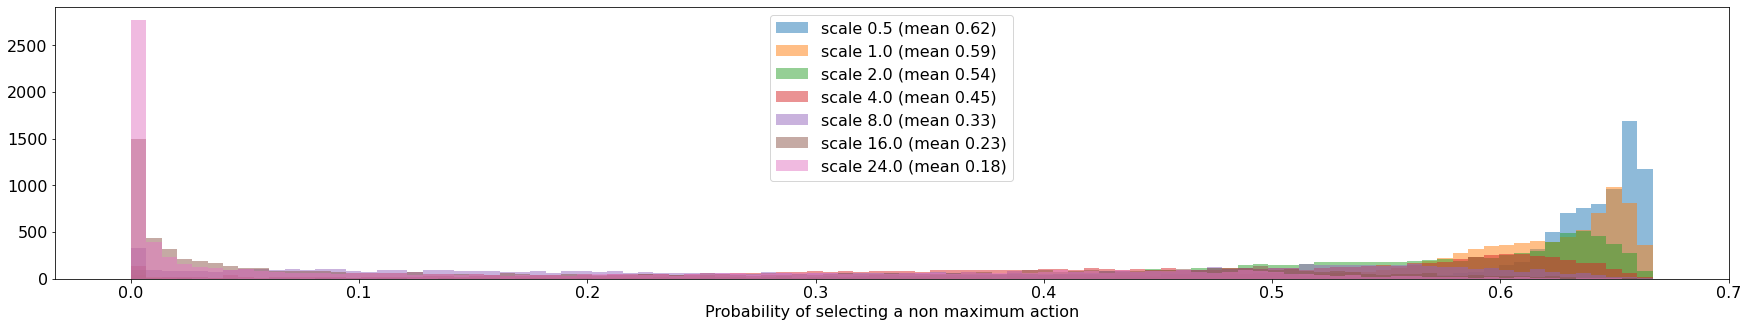

In [102]:
bins = np.linspace(0, 2./3, 100)
for scale in [0.5, 1, 2, 4, 8, 16, 24]:
    probabilities = compute_probability_of_sampling_non_maximum_action(q_values, scale=scale)
    label = 'scale %.1f (mean %.2f)' % (scale, np.mean(probabilities))
    plt.hist(probabilities, bins, label=label, alpha=0.5)
plt.xlabel('Probability of selecting a non maximum action')
plt.legend(loc=0);

This is really interesting, it shows that even when using big scale values there is a much bigger probability of selecting non maximum action compared to epsilon greedy.

#### Comparison

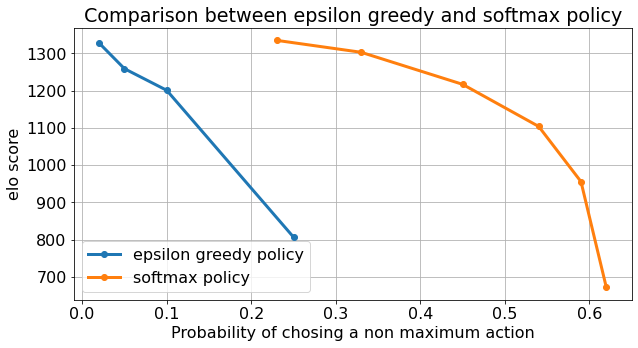

In [111]:
plt.figure(figsize=(10, 5))
plt.title('Comparison between epsilon greedy and softmax policy')
epsilon = [0.02, 0.05, 0.1, 0.25]
epsilon_elo_multi = [1328, 1259, 1201, 807]
plt.plot(epsilon, epsilon_elo_multi, label='epsilon greedy policy', marker='o')

softmax_non_maximum_action_probability = [0.62, 0.59, 0.54, 0.45, 0.33, 0.23]
softmax_elo_multi = [672, 956, 1104, 1217, 1303, 1335]
plt.plot(softmax_non_maximum_action_probability, softmax_elo_multi, label='softmax policy', marker='o')
plt.grid()
plt.ylabel('elo score')
plt.xlabel('Probability of chosing a non maximum action')
plt.legend(loc=0);

This looks very promising, because we are able to achieve very good elo scores while mantaining a exploratory policy. So it's time to generate matches and train.

### Generation

I'm going to start with a scale of 8. I will play against other q value agents with same policy.

In [20]:
agent_base = '../data/agents/quantum/softmax_8_quantum.py'
reward_name = 'ranking_reward_-4_4'

for n_matches in [2000]:
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    play_matches_in_parallel_and_save_history(agents=[agent_base]*4, n_matches=n_matches, output_path=output_path)
    
    saved_games_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
            os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
        reward_name, os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    create_train_data_from_saved_matches([saved_games_path], reward_name, output_path)

2021-03-27 11:12:00,365 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.68 GB


  0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-27 11:18:09,509 - hungry_geese.utils - INFO - ram_memory used: 2.97 GB	 available: 58.10 GB
2021-03-27 11:18:09,510 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/softmax_8_quantum_vs_softmax_8_quantum_matches_2000.json
2021-03-27 11:18:36,534 - hungry_geese.utils - INFO - ram_memory used: 0.35 GB	 available: 60.74 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-27 11:18:36,574 - hungry_geese.utils - INFO - ram_memory used: 0.35 GB	 available: 60.73 GB
2021-03-27 11:18:44,432 - hungry_geese.utils - INFO - ram_memory used: 2.18 GB	 available: 58.91 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-27 11:20:09,606 - hungry_geese.utils - INFO - ram_memory used: 2.78 GB	 available: 58.31 GB
2021-03-27 11:20:09,606 - __main__ - INFO - Going to combine the data
2021-03-27 11:20:10,049 - hungry_geese.utils - INFO - ram_memory used: 3.77 GB	 available: 57.29 GB
2021-03-27 11:20:10,050 - __main__ - INFO - Size of the boards is 1.6 GB ([1.6, 0.0, 0.0, 0.0] [1.7 GB])
2021-03-27 11:20:10,051 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/softmax_8_quantum_vs_softmax_8_quantum_matches_2000.npz
2021-03-27 11:20:30,099 - hungry_geese.utils - INFO - ram_memory used: 2.06 GB	 available: 59.03 GB


In [21]:
agent_base = '../data/agents/quantum/softmax_8_quantum.py'
reward_name = 'ranking_reward_-4_4'

for n_matches in [10000]:
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    play_matches_in_parallel_and_save_history(agents=[agent_base]*4, n_matches=n_matches, output_path=output_path)
    
    saved_games_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
            os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
        reward_name, os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    create_train_data_from_saved_matches([saved_games_path], reward_name, output_path)

2021-03-27 11:23:26,604 - hungry_geese.utils - INFO - ram_memory used: 2.06 GB	 available: 59.03 GB


  0%|          | 0/10000 [00:00<?, ?it/s]

2021-03-27 11:54:17,560 - hungry_geese.utils - INFO - ram_memory used: 15.21 GB	 available: 45.72 GB
2021-03-27 11:54:17,561 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/softmax_8_quantum_vs_softmax_8_quantum_matches_10000.json
2021-03-27 11:56:33,121 - hungry_geese.utils - INFO - ram_memory used: 2.08 GB	 available: 58.79 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-27 11:56:33,139 - hungry_geese.utils - INFO - ram_memory used: 2.08 GB	 available: 58.79 GB
2021-03-27 11:57:10,790 - hungry_geese.utils - INFO - ram_memory used: 11.24 GB	 available: 49.61 GB


Creating game data:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-03-27 12:04:43,381 - hungry_geese.utils - INFO - ram_memory used: 12.56 GB	 available: 47.92 GB
2021-03-27 12:04:43,382 - __main__ - INFO - Going to combine the data
2021-03-27 12:04:45,636 - hungry_geese.utils - INFO - ram_memory used: 17.49 GB	 available: 43.00 GB
2021-03-27 12:04:45,637 - __main__ - INFO - Size of the boards is 8.2 GB ([8.2, 0.2, 0.1, 0.0] [8.5 GB])
2021-03-27 12:04:45,638 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/softmax_8_quantum_vs_softmax_8_quantum_matches_10000.npz
2021-03-27 12:06:26,620 - hungry_geese.utils - INFO - ram_memory used: 8.94 GB	 available: 51.46 GB


In [38]:
agent_base = '../data/agents/quantum/softmax_8_quantum.py'
reward_name = 'ranking_reward_-4_4'

for n_matches in [10001, 10002, 10003]:
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    play_matches_in_parallel_and_save_history(agents=[agent_base]*4, n_matches=n_matches, output_path=output_path)

2021-03-27 18:36:27,853 - hungry_geese.utils - INFO - ram_memory used: 0.44 GB	 available: 59.18 GB


  0%|          | 0/10001 [00:00<?, ?it/s]

2021-03-27 19:06:59,313 - hungry_geese.utils - INFO - ram_memory used: 13.55 GB	 available: 46.06 GB
2021-03-27 19:06:59,313 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/softmax_8_quantum_vs_softmax_8_quantum_matches_10001.json
2021-03-27 19:09:10,997 - hungry_geese.utils - INFO - ram_memory used: 0.47 GB	 available: 59.19 GB
2021-03-27 19:09:10,998 - hungry_geese.utils - INFO - ram_memory used: 0.47 GB	 available: 59.20 GB


  0%|          | 0/10002 [00:00<?, ?it/s]

2021-03-27 19:40:17,492 - hungry_geese.utils - INFO - ram_memory used: 13.56 GB	 available: 45.29 GB
2021-03-27 19:40:17,492 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/softmax_8_quantum_vs_softmax_8_quantum_matches_10002.json
2021-03-27 19:42:29,625 - hungry_geese.utils - INFO - ram_memory used: 0.47 GB	 available: 58.40 GB
2021-03-27 19:42:29,626 - hungry_geese.utils - INFO - ram_memory used: 0.47 GB	 available: 58.40 GB


  0%|          | 0/10003 [00:00<?, ?it/s]

2021-03-27 20:13:19,408 - hungry_geese.utils - INFO - ram_memory used: 13.55 GB	 available: 46.07 GB
2021-03-27 20:13:19,409 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/softmax_8_quantum_vs_softmax_8_quantum_matches_10003.json
2021-03-27 20:15:29,641 - hungry_geese.utils - INFO - ram_memory used: 0.47 GB	 available: 59.19 GB


In [40]:
n_matches = 40000
saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in range(10000, 10004)]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
    reward_name, os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/4 [00:00<?, ?it/s]

2021-03-27 20:53:31,264 - hungry_geese.utils - INFO - ram_memory used: 0.47 GB	 available: 59.10 GB
2021-03-27 20:54:11,710 - hungry_geese.utils - INFO - ram_memory used: 9.61 GB	 available: 49.93 GB


Creating game data:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-03-27 21:01:28,071 - hungry_geese.utils - INFO - ram_memory used: 12.61 GB	 available: 46.95 GB
2021-03-27 21:02:05,282 - hungry_geese.utils - INFO - ram_memory used: 18.16 GB	 available: 41.38 GB


Creating game data:   0%|          | 0/10001 [00:00<?, ?it/s]

2021-03-27 21:09:11,390 - hungry_geese.utils - INFO - ram_memory used: 23.35 GB	 available: 36.13 GB
2021-03-27 21:09:44,589 - hungry_geese.utils - INFO - ram_memory used: 26.73 GB	 available: 32.69 GB


Creating game data:   0%|          | 0/10002 [00:00<?, ?it/s]

2021-03-27 21:16:49,202 - hungry_geese.utils - INFO - ram_memory used: 33.23 GB	 available: 26.24 GB
2021-03-27 21:17:26,886 - hungry_geese.utils - INFO - ram_memory used: 35.28 GB	 available: 24.18 GB


Creating game data:   0%|          | 0/10003 [00:00<?, ?it/s]

2021-03-27 21:24:30,851 - hungry_geese.utils - INFO - ram_memory used: 42.59 GB	 available: 16.86 GB
2021-03-27 21:24:30,852 - __main__ - INFO - Going to combine the data
2021-03-27 21:25:27,122 - hungry_geese.utils - INFO - ram_memory used: 60.71 GB	 available: 3.67 GB
2021-03-27 21:25:27,188 - __main__ - INFO - Size of the boards is 32.7 GB ([32.7, 0.9, 0.4, 0.1] [34.1 GB])
2021-03-27 21:25:27,191 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/softmax_8_quantum_vs_softmax_8_quantum_matches_40000.npz
2021-03-27 21:32:06,913 - hungry_geese.utils - INFO - ram_memory used: 26.75 GB	 available: 36.64 GB


### Evaluation

The biggest changes from the previous experiments is that we are using a softmax policy for playing, and that we are going to save multiple versions of the model to see how it changes over time. On a first experiment I will use quantum model as the initial weights, and on a second experiment I will train from zero and compare.

I have created a new function to evaluate models.

#### Baseline (lr 1e-3)

In [22]:
df

,multi,single
epoch_001_val_loss0.088,1344.0,1346.0
epoch_002_val_loss0.085,1318.0,1359.0
epoch_003_val_loss0.085,1310.0,1315.0
epoch_004_val_loss0.084,1270.0,1281.0
epoch_005_val_loss0.083,1141.0,1087.0
epoch_006_val_loss0.082,1206.0,1209.0
epoch_007_val_loss0.083,1173.0,1171.0
epoch_008_val_loss0.083,1134.0,1111.0
epoch_009_val_loss0.082,1104.0,1081.0


This shows that the agent is becoming worse epoch after epoch. I think that the 

#### Learning rate 5e-4

In [37]:
del df
model_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/29_softmax_policy/06_softmax_8_quantum_vs_softmax_8_quantum_reward_-4_4_x128_10000_lr4e4/epoch_*.h5'))
if 'df' not in locals(): df = pd.DataFrame()
for model_filepath in tqdm(model_filepaths):
    name = os.path.splitext(os.path.basename(model_filepath))[0]
    if name in df.index:
        continue
    print(df)
    ret = simple_model_evaluation(model_filepath, n_matches=500)
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
clear_output()
df

,multi,single
epoch_001_val_loss0.087,1367.0,1417.0
epoch_002_val_loss0.085,1360.0,1367.0
epoch_003_val_loss0.084,1363.0,1370.0
epoch_004_val_loss0.083,1391.0,1371.0
epoch_005_val_loss0.083,1411.0,1352.0
epoch_006_val_loss0.082,1374.0,1349.0
epoch_007_val_loss0.082,1388.0,1428.0
epoch_008_val_loss0.082,1393.0,1397.0
epoch_009_val_loss0.082,1361.0,1379.0
epoch_010_val_loss0.082,1411.0,1436.0


#### Learning rate 2e-4

In [ ]:
del df
model_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/29_softmax_policy/05_softmax_8_quantum_vs_softmax_8_quantum_reward_-4_4_x128_10000_lr2e4/epoch_*.h5'))
if 'df' not in locals(): df = pd.DataFrame()
for model_filepath in tqdm(model_filepaths):
    name = os.path.splitext(os.path.basename(model_filepath))[0]
    if name in df.index:
        continue
    print(df)
    ret = simple_model_evaluation(model_filepath, n_matches=500)
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
clear_output()
df

In [35]:
df

,multi,single
epoch_001_val_loss0.089,1357.0,1404.0
epoch_002_val_loss0.087,1365.0,1384.0
epoch_003_val_loss0.085,1388.0,1387.0
epoch_004_val_loss0.084,1360.0,1411.0
epoch_005_val_loss0.083,1398.0,1390.0
epoch_006_val_loss0.083,1392.0,1431.0
epoch_007_val_loss0.083,1380.0,1417.0
epoch_008_val_loss0.082,1381.0,1419.0
epoch_009_val_loss0.082,1400.0,1397.0
epoch_010_val_loss0.082,1392.0,1431.0


#### Learning rate 1e-4

In [33]:
model_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/29_softmax_policy/02_softmax_8_quantum_vs_softmax_8_quantum_reward_-4_4_x128_10000_lr1e4/epoch_*.h5'))
if 'df' not in locals(): df = pd.DataFrame()
for model_filepath in tqdm(model_filepaths):
    name = os.path.splitext(os.path.basename(model_filepath))[0]
    if name in df.index:
        continue
    print(df)
    ret = simple_model_evaluation(model_filepath, n_matches=500)
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
clear_output()
df

,multi,single
epoch_001_val_loss0.090,1321.0,1373.0
epoch_002_val_loss0.088,1372.0,1384.0
epoch_003_val_loss0.087,1354.0,1391.0
epoch_004_val_loss0.087,1375.0,1369.0
epoch_005_val_loss0.086,1370.0,1365.0
epoch_006_val_loss0.085,1373.0,1379.0
epoch_007_val_loss0.085,1393.0,1415.0
epoch_008_val_loss0.084,1400.0,1380.0
epoch_009_val_loss0.084,1368.0,1404.0
epoch_010_val_loss0.083,1392.0,1378.0


In [23]:
model_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/29_softmax_policy/02_softmax_8_quantum_vs_softmax_8_quantum_reward_-4_4_x128_10000_lr1e4/epoch_*.h5'))[::5]
if 'df' not in locals(): df = pd.DataFrame()
for model_filepath in tqdm(model_filepaths):
    name = os.path.splitext(os.path.basename(model_filepath))[0]
    if name in df.index:
        continue
    print(df)
    ret = simple_model_evaluation(model_filepath, n_matches=500)
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
clear_output()
df

,multi,single
epoch_001_val_loss0.090,1363.0,1390.0
epoch_002_val_loss0.088,1390.0,1358.0
epoch_003_val_loss0.087,1368.0,1392.0
epoch_004_val_loss0.087,1389.0,1366.0
epoch_005_val_loss0.086,1372.0,1376.0
epoch_006_val_loss0.085,1363.0,1393.0
epoch_007_val_loss0.085,1391.0,1413.0
epoch_008_val_loss0.084,1375.0,1402.0
epoch_011_val_loss0.084,1394.0,1370.0
epoch_016_val_loss0.082,1382.0,1403.0


#### Learning rate 1e-5

In [26]:
model_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/29_softmax_policy/03_softmax_8_quantum_vs_softmax_8_quantum_reward_-4_4_x128_10000_lr1e5/epoch_*.h5'))
if 'df' not in locals(): df = pd.DataFrame()
for model_filepath in tqdm(model_filepaths):
    name = os.path.splitext(os.path.basename(model_filepath))[0]
    if name in df.index:
        continue
    print(df)
    ret = simple_model_evaluation(model_filepath, n_matches=500)
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
clear_output()
df

,multi,single
epoch_001_val_loss0.095,1317.0,1359.0
epoch_002_val_loss0.093,1334.0,1368.0
epoch_003_val_loss0.093,1333.0,1323.0
epoch_004_val_loss0.092,1322.0,1354.0
epoch_005_val_loss0.092,1348.0,1379.0
epoch_006_val_loss0.091,1350.0,1342.0
epoch_007_val_loss0.091,1379.0,1361.0
epoch_008_val_loss0.091,1340.0,1382.0
epoch_009_val_loss0.090,1370.0,1385.0
epoch_010_val_loss0.090,1364.0,1393.0


#### From zero

In [ ]:
model_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/29_softmax_policy/04_softmax_8_quantum_vs_softmax_8_quantum_reward_-4_4_x128_10000_from_zero/epoch_*.h5'))
if 'df' not in locals(): df = pd.DataFrame()
for model_filepath in tqdm(model_filepaths):
    name = os.path.splitext(os.path.basename(model_filepath))[0]
    if name in df.index:
        continue
    print(df)
    ret = simple_model_evaluation(model_filepath, n_matches=500)
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
clear_output()
df

In [30]:
df

,multi,single
epoch_001_val_loss0.104,983.0,962.0
epoch_002_val_loss0.097,864.0,885.0
epoch_003_val_loss0.094,782.0,759.0
epoch_004_val_loss0.091,818.0,834.0
epoch_005_val_loss0.088,712.0,726.0
epoch_006_val_loss0.087,677.0,685.0
epoch_007_val_loss0.086,582.0,540.0
epoch_008_val_loss0.085,711.0,607.0
epoch_009_val_loss0.084,667.0,683.0
epoch_010_val_loss0.084,544.0,600.0


It is not capable of learning anything useful when training from zero.

#### 40k matches

In [15]:
model_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/30_softmax_policy_more_data/*/epoch_*.h5'))
if 'df' not in locals(): df = pd.DataFrame()
for model_filepath in tqdm(model_filepaths):
    #name = os.path.basename(os.path.dirname(model_filepath)) + os.path.basename(model_filepath)
    name = model_filepath.split('40000_')[-1].split('_val_loss')[0]
    if name in df.index:
        continue
    print(df)
    ret = simple_model_evaluation(model_filepath, n_matches=500)
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
clear_output()
df

,multi,single
lr1e3/epoch_001,1304.0,1292.0
lr1e3/epoch_002,1093.0,1107.0
lr1e3/epoch_003,995.0,1006.0
lr1e3/epoch_004,815.0,805.0
lr1e3/epoch_005,870.0,925.0
lr4e4/epoch_001,1412.0,1413.0
lr4e4/epoch_002,1393.0,1396.0
lr4e4/epoch_003,1377.0,1388.0
lr4e4/epoch_004,1327.0,1340.0
lr4e4/epoch_005,1352.0,1355.0


In [26]:
df.sort_values('multi', ascending=False).head()

,multi,single
lr1e4/epoch_004,1415.0,1429.0
lr4e4/epoch_001,1412.0,1413.0
lr2e4/epoch_005,1407.0,1429.0
lr1e4/epoch_003,1405.0,1400.0
lr2e4/epoch_002,1397.0,1408.0


We can get some good scores, but the differences with quantum agent do not seem to be significative. Let's compute quantum agent scores according
to current evaluation.

In [27]:
simple_model_evaluation('../data/agents/quantum/best_model.h5')

/tmp/tmpb6zwa1gp/agent.py
Multi agent elo score: 1347
Single agent elo score: 1373


(1347, 1373)

Wait! This is relevant! When measured against the same baseline of all the agents we can see that quantum agent does not perform as well as its fixed elo score indicates.

So this means that the agent with (1415, 1429) scores is significatively better than the baseline.

Then we should try to use that agent to train a new iteration, and if it works then we could start working on a automate ladder.
I should aim at a score of (1465, 1480) to have significative improvement.

## Trying to iterate

### Generation

In [15]:
def simple_model_softmax_policy_data_generation(model_path, softmax_scale, name, n_matches, reward_name):
    model_path = os.path.realpath(model_path)
    text = """
import os
from hungry_geese.agents import SoftmaxAgent, EpsilonAgent

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import tensorflow as tf

model = tf.keras.models.load_model('model_path', compile=False)
model = tf.keras.models.Model(inputs=model.inputs[:2], outputs=model.layers[-3].output)
softmax_agent = SoftmaxAgent(model, scale=softmax_scale)

def agent(obs, config):
    return softmax_agent(obs, config)
    """
    text = text.replace('model_path', model_path)
    text = text.replace('softmax_scale', str(softmax_scale))
    with tempfile.TemporaryDirectory() as tempdir:
        agent_filepath = os.path.join(tempdir, 'agent.py')
        with open(agent_filepath, 'w') as f:
            f.write(text)
        
        saved_games_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_matches_%i.json' % (name, n_matches)
        play_matches_in_parallel_and_save_history(agents=[agent_filepath]*4, n_matches=n_matches, output_path=saved_games_path)

        output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, name, n_matches)
        create_train_data_from_saved_matches([saved_games_path], reward_name, output_path)

In [39]:
simple_model_softmax_policy_data_generation(
    model_path='/mnt/hdd0/Kaggle/hungry_geese/models/30_softmax_policy_more_data/04_softmax_8_quantum_vs_softmax_8_quantum_reward_-4_4_x128_40000_lr1e4/epoch_004_val_loss0.081.h5',
    softmax_scale=8,
    n_matches=2000,
    name='20210328_it1',
    reward_name='ranking_reward_-4_4')

2021-03-28 09:33:59,133 - hungry_geese.utils - INFO - ram_memory used: 0.46 GB	 available: 60.22 GB


  0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-28 09:39:01,435 - hungry_geese.utils - INFO - ram_memory used: 2.70 GB	 available: 57.95 GB
2021-03-28 09:39:01,436 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/20210328_it1_matches_2000.json
2021-03-28 09:39:23,572 - hungry_geese.utils - INFO - ram_memory used: 0.46 GB	 available: 60.19 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-28 09:39:23,591 - hungry_geese.utils - INFO - ram_memory used: 0.46 GB	 available: 60.19 GB
2021-03-28 09:39:30,282 - hungry_geese.utils - INFO - ram_memory used: 2.01 GB	 available: 58.62 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-28 09:40:35,429 - hungry_geese.utils - INFO - ram_memory used: 2.47 GB	 available: 58.18 GB
2021-03-28 09:40:35,430 - __main__ - INFO - Going to combine the data
2021-03-28 09:40:35,812 - hungry_geese.utils - INFO - ram_memory used: 3.12 GB	 available: 57.53 GB
2021-03-28 09:40:35,813 - __main__ - INFO - Size of the boards is 1.3 GB ([1.3, 0.0, 0.0, 0.0] [1.4 GB])
2021-03-28 09:40:35,814 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/20210328_it1_matches_2000.npz
2021-03-28 09:40:50,106 - hungry_geese.utils - INFO - ram_memory used: 1.76 GB	 available: 58.85 GB


In [40]:
simple_model_softmax_policy_data_generation(
    model_path='/mnt/hdd0/Kaggle/hungry_geese/models/30_softmax_policy_more_data/04_softmax_8_quantum_vs_softmax_8_quantum_reward_-4_4_x128_40000_lr1e4/epoch_004_val_loss0.081.h5',
    softmax_scale=8,
    n_matches=10000,
    name='20210328_it1',
    reward_name='ranking_reward_-4_4')

2021-03-28 09:40:50,145 - hungry_geese.utils - INFO - ram_memory used: 1.76 GB	 available: 58.85 GB


  0%|          | 0/10000 [00:00<?, ?it/s]

2021-03-28 10:06:52,341 - hungry_geese.utils - INFO - ram_memory used: 12.93 GB	 available: 47.66 GB
2021-03-28 10:06:52,342 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/20210328_it1_matches_10000.json
2021-03-28 10:08:41,447 - hungry_geese.utils - INFO - ram_memory used: 1.77 GB	 available: 58.87 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-28 10:08:41,466 - hungry_geese.utils - INFO - ram_memory used: 1.77 GB	 available: 58.87 GB
2021-03-28 10:09:13,374 - hungry_geese.utils - INFO - ram_memory used: 9.55 GB	 available: 51.08 GB


Creating game data:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-03-28 10:14:39,690 - hungry_geese.utils - INFO - ram_memory used: 10.80 GB	 available: 49.83 GB
2021-03-28 10:14:39,691 - __main__ - INFO - Going to combine the data
2021-03-28 10:14:41,584 - hungry_geese.utils - INFO - ram_memory used: 13.90 GB	 available: 46.74 GB
2021-03-28 10:14:41,585 - __main__ - INFO - Size of the boards is 6.5 GB ([6.5, 0.2, 0.1, 0.0] [6.7 GB])
2021-03-28 10:14:41,586 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/20210328_it1_matches_10000.npz
2021-03-28 10:15:54,936 - hungry_geese.utils - INFO - ram_memory used: 7.16 GB	 available: 53.56 GB


### Evaluation

In [21]:
model_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/31_iterating_over_softmax_policy/*/epoch_*.h5'))
if 'df' not in locals(): df = pd.DataFrame()
for model_filepath in tqdm(model_filepaths):
    name = model_filepath.split('31_iterating_over_softmax_policy/')[-1].split('_val_loss')[0]
    if name in df.index:
        continue
    print(df)
    ret = simple_model_evaluation(model_filepath, n_matches=500)
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
clear_output()
df

,multi,single
01_it1_2000_lr4e4/epoch_001,1315.0,1339.0
01_it1_2000_lr4e4/epoch_002,1346.0,1330.0
01_it1_2000_lr4e4/epoch_003,1390.0,1398.0
01_it1_2000_lr4e4/epoch_004,1347.0,1357.0
01_it1_2000_lr4e4/epoch_005,1400.0,1357.0
02_it1_2000_lr2e4/epoch_001,1358.0,1318.0
02_it1_2000_lr2e4/epoch_002,1368.0,1384.0
02_it1_2000_lr2e4/epoch_003,1407.0,1404.0
02_it1_2000_lr2e4/epoch_004,1362.0,1355.0
02_it1_2000_lr2e4/epoch_005,1389.0,1425.0


No improvement.

However I think I have to automatize the cycle of playing, training and evaluation to have a better picture of the problem.

In [24]:
df.sort_values('multi', ascending=False).head()

,multi,single
03_it1_2000_lr1e4/epoch_002,1409.0,1396.0
02_it1_2000_lr2e4/epoch_003,1407.0,1404.0
05_it1_10000_lr2e4/epoch_002,1403.0,1384.0
06_it1_10000_lr1e4/epoch_002,1400.0,1396.0
01_it1_2000_lr4e4/epoch_005,1400.0,1357.0


## Useful snippets

In [ ]:
agent_base = '../data/agents/quantum/epsilon_quantum_010.py'
best_5_agents = [agents[name] for name in initial_elo_ranking.index.values[:4]]
best_5_agents += ['/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/04_epsilon010_vs_best5_reward_-4_4_x128_80000_pretrained/q_value_agent.py']
sampling_agent_func = lambda: [agent_base] + np.random.choice(best_5_agents, 3).tolist()

for n_matches in [8000, 39000, 40000]:
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    play_matches_in_parallel_and_save_history(agents=sampling_agent_func, n_matches=n_matches, output_path=output_path)
    
reward_name = 'ranking_reward_-4_4'

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [8000]]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_it2_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], 8000)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [39000, 40000]]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_it2_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], 80000)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

In [ ]:
agent_names = initial_elo_ranking.index.values.tolist()[:4]
output_folder = '../data/saved_games/02_quantum'
save_html_games([agents[name] for name in agent_names], output_folder, n_games=10)

In [ ]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/01_epsilon025_reward_-4_4_x128_30000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

In [ ]:
agent_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/28_architecture_study/*/q_value_agent.py'))
print(agent_filepaths)
df = pd.DataFrame()
for agent_filepath in agent_filepaths:
    print(df)
    ret = simple_agent_evaluation(agent_filepath, n_matches=500)
    name = os.path.basename(os.path.dirname(agent_filepath))
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
df

## Summary